# Semantic Segmentation: Fluorescent Neuronal Cells 

This time, we will finetune the `MobileVit` model on the [`Fluorescent Neuronal Cells`](https://www.kaggle.com/datasets/nbroad/fluorescent-neuronal-cells) dataset. As the title suggest the goal of this project is to predict a mask for a given image. 

The images are mice brain slices obtained through fluorescent microscopy. The mask predicted is a simple image with zeros for the background, and ones for the pixels where a neuron has been detected. This makes the problem simple with just two classes to detect: background and neurons.

You can access the [`git repo`](https://github.com/mmenendezg/mobilevit-fluorescent-cells) to see the CLI interface implementation of this project.

## Setup

Let's start by importing all the libraries we will use in this project:

In [1]:
import os
import random
import yaml

import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from icecream import ic

import torch
from torch.utils.data import DataLoader
from torch import nn

import albumentations as A
import optuna

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from transformers import (
    AutoImageProcessor,
    MobileViTForSemanticSegmentation,
)
from datasets import Dataset, DatasetDict
import evaluate

Let's also add the constants for the project:

In [69]:
# Model checkpoitn at the HuggingFace Hub
MODEL_CHECKPOINT = "apple/deeplabv3-mobilevit-xx-small"

# Define the accelerator
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps:0")
    ACCELERATOR = "mps"
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    ACCELERATOR = "gpu"
else:
    DEVICE = torch.device("cpu")
    ACCELERATOR = "cpu"

# Path of the images
RAW_DATA_PATH = "../data/raw/"

# Classes of masks
CLASSES = {0: "Background", 1: "Neuron"}

# Size of the preprocessed image
IMG_SIZE = [256, 256]

# Path of the config file with the hyperparameters 
HPARAMS_FILE = "../config/fluorescent_mobilevit_hps.yaml"

## Dataset

The original structure of the dataset is the following:

```
data/raw
├── all_images
│   ├── LICENSE.txt
│   └── images
│       ├── 37_y.png
│       ├── ...
│       └── Mar43S1C5R3_DMr_200x_o.png
└── all_masks
    ├── LICENSE.txt
    └── masks
        ├── 37_y.png
        ├── ...
        └── Mar43S1C5R3_DMr_200x_o.png
```

The images and masks share the same name. This makes them easy to match when creating the dataset. Also, there is no training, validation or test folder. There is only one folder for all the images, therefore, we need to split the images. 

Before start working on the dataset, it would be good to see an example of an image and its mask to get familiar with the data. Here a random image has been selected to be displayed with the mask at the left.

In [3]:
image_name = random.choice(
    os.listdir(os.path.join(RAW_DATA_PATH, "all_images", "images"))
)
image_path = os.path.join(RAW_DATA_PATH, "all_images", "images", image_name)
mask_path = os.path.join(RAW_DATA_PATH, "all_masks", "masks", image_name)

orig_image = np.array(Image.open(image_path), dtype=np.uint8)
orig_mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)

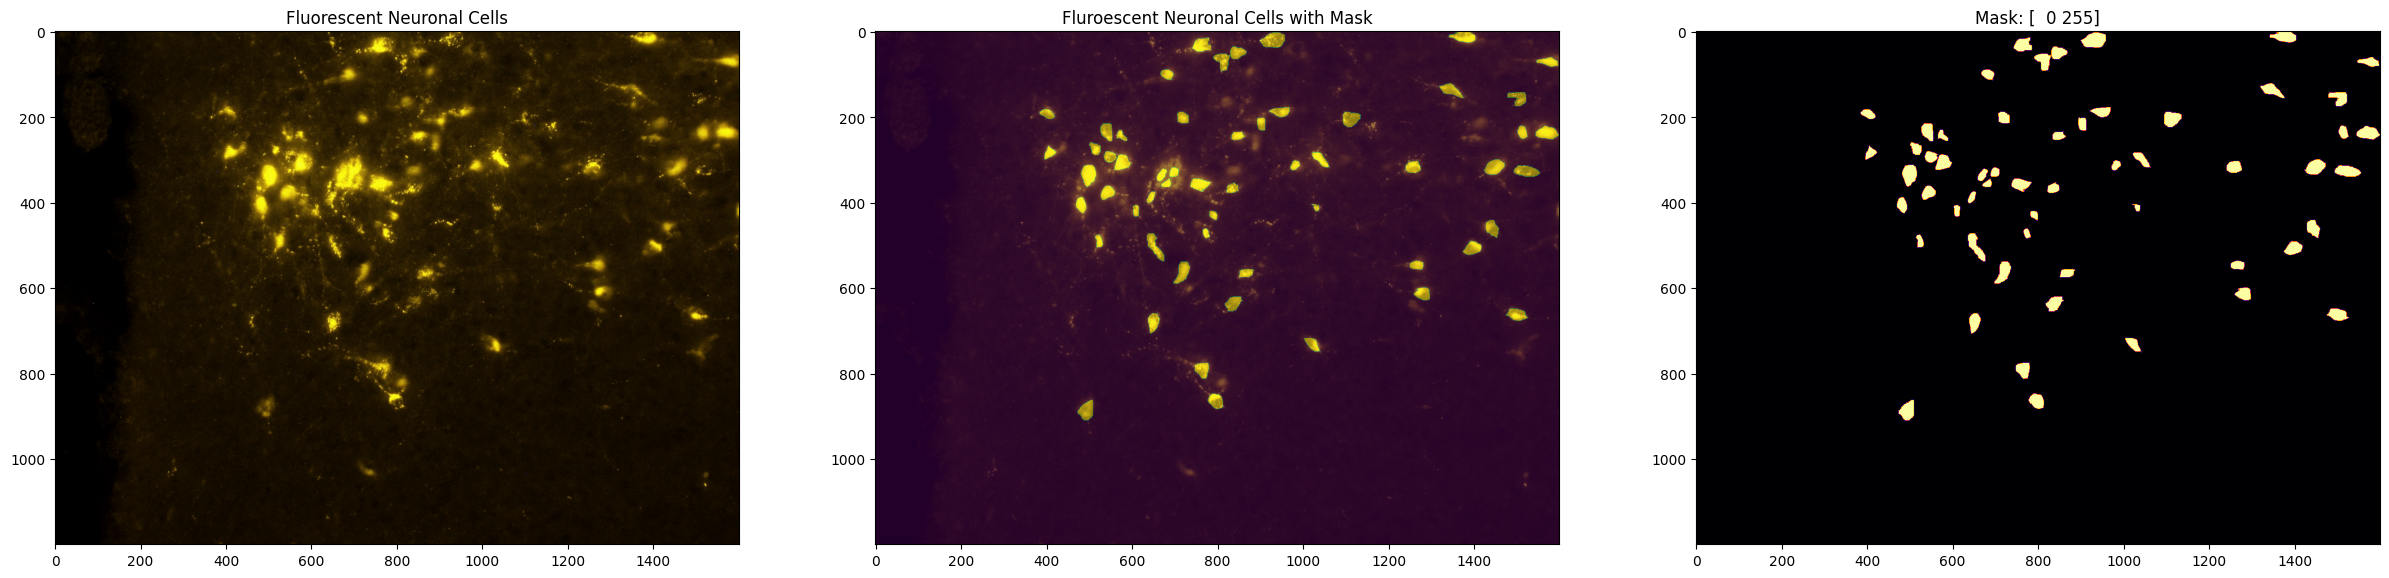

In [4]:
plt.figure(figsize=(30, 15))
plt.subplot(1, 3, 1)
plt.imshow(orig_image)
plt.title("Fluorescent Neuronal Cells")
plt.subplot(1, 3, 2)
plt.imshow(orig_image)
plt.imshow(orig_mask, cmap="viridis", alpha=0.5)
plt.title("Fluroescent Neuronal Cells with Mask")
plt.subplot(1, 3, 3)
plt.imshow(orig_mask, cmap="inferno")
plt.title(f"Mask: {np.unique(orig_mask)}")
plt.show()

The mask (left image) contains only two possible values: zero for the background and 255 for the actual neurons. In many cases the background is not consider as a class, but in our case we will consider it. 

The dataset contains a total of 283 images and 283 masks. Since we will use transfer learning (we will not train the model from scratch) we do not need a big number of examples, but augmenting our dataset will always help the model to generalize better and avoid overfitting. However, augmenting masks may be difficult, specially if we would like to apply spatial transformations (crops, rotations, resize), because we need to make sure the augmented masks match the augmented images.

Luckily for us, we have the `albumentations` package that will take care of this for us. We will create a function that shows how this is done. 

First, the name of a random image is picked. As we checked before, the name of the image matches the name of the mask. This helps us get the image and the mask using the same string. When loading the image, the image has to be converted to a numpy array, because `albumentations` expects a numpy array as input.

Then, we create the pipeline of augmentations using the `A.Compose()` class. We include a horizontal flip, change in the brightness, contrast, gamma, hue and saturation. Once created, we pass it the image and mask (we can pass several masks, but this is not the case), and returns a dictionary with the augmented output. 

Finally, the function plots the original and the augmented images with their masks.

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 309d5326-c4ad-4e8b-a1c2-f7e75ebc07c9)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


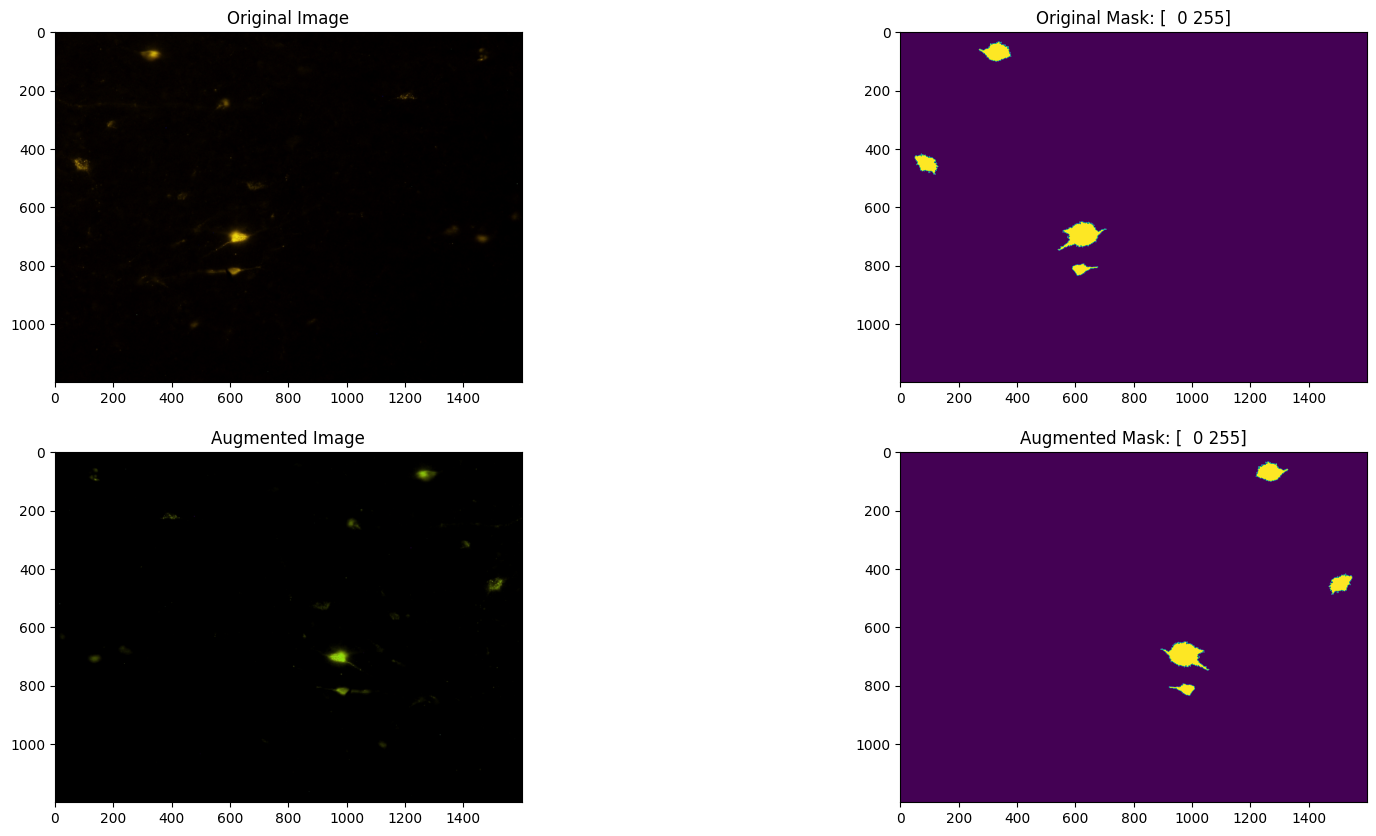

In [62]:
def test_augmentation():
    # Select a random image and get the mask as well
    image_name = random.choice(
        os.listdir(os.path.join(RAW_DATA_PATH, "all_images", "images"))
    )
    image_path = os.path.join(RAW_DATA_PATH, "all_images", "images", image_name)
    mask_path = os.path.join(RAW_DATA_PATH, "all_masks", "masks", image_name)

    # Convert both the image and the mask to numpy arrays
    orig_image = np.array(Image.open(image_path), dtype=np.uint8)
    orig_mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)

    # Create the augmentation pipeline
    image_augmentator = A.Compose(
        [
            A.HorizontalFlip(p=0.8),
            A.RandomBrightnessContrast(p=0.8),
            A.RandomGamma(p=0.8),
            A.HueSaturationValue(p=0.8),
        ]
    )

    # Pass the images and masks to the augmentation pipeline
    augmented_images = image_augmentator(image=orig_image, mask=orig_mask)
    aug_image = augmented_images["image"]
    aug_mask = augmented_images["mask"]

    # Plot the augmented results
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(orig_image)
    plt.title("Original Image")
    plt.subplot(2, 2, 2)
    plt.imshow(orig_mask)
    plt.title(f"Original Mask: {np.unique(orig_mask)}")
    plt.subplot(2, 2, 3)
    plt.imshow(aug_image)
    plt.title("Augmented Image")
    plt.subplot(2, 2, 4)
    plt.imshow(aug_mask)
    plt.title(f"Augmented Mask: {np.unique(aug_mask)}")
    plt.show()


test_augmentation()

We can see in the two inferior images that it has rotated, and the rest of parameters have changed. The mask on the other side, only rotated. This is good because we do not want the values of the mask's pixels to change. A change in the value of the pixels means changing the class of the pixel. 

The next step is to create the dataset. For this we will use the `pl.LightningDataModule` that PyTorch Lightning provides. The data module not only generates the datasets when needed, it allows us to specify how to load the images and the instructions to preprocess the images.

In [10]:
class FluorescentNeuronalDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir=RAW_DATA_PATH, dataset_size=1.0):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_processor = AutoImageProcessor.from_pretrained(
            MODEL_CHECKPOINT, do_reduce_labels=False
        )
        self.image_resizer = A.Compose([A.Resize(width=IMG_SIZE[0], height=IMG_SIZE[1], interpolation=cv2.INTER_NEAREST)])
        self.image_augmentator = A.Compose(
            [
                A.HorizontalFlip(p=0.6),
                A.VerticalFlip(p=0.6),
                A.RandomBrightnessContrast(p=0.6),
                A.RandomGamma(p=0.6),
                A.HueSaturationValue(p=0.6),
            ]
        )

        # Percentage of the dataset
        self.dataset_size = dataset_size

    def _create_dataset(self):
        # Get the list of iames
        images_path = os.path.join(self.data_dir, "all_images", "images")
        masks_path = os.path.join(self.data_dir, "all_masks", "masks")
        list_images = os.listdir(images_path)

        # Determine the size of the dataset
        if self.dataset_size < 1.0:
            n_images = int(len(list_images) * self.dataset_size)
            list_images = list_images[:n_images]

        # Load the images and convert them to numpy arrays
        images = []
        masks = []
        for image_filename in list_images:
            image_path = os.path.join(images_path, image_filename)
            mask_path = os.path.join(masks_path, image_filename)

            image = np.array(Image.open(image_path).convert("RGB"), dtype=np.uint8)
            mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)
            mask = (mask / 255).astype(np.uint8)

            images.append(image)
            masks.append(mask)

        # Create the dataset
        dataset = Dataset.from_dict({"image": images, "mask": masks})

        # Split the dataset into train, val, and test sets
        dataset = dataset.train_test_split(test_size=0.1)
        train_val = dataset["train"]
        test_ds = dataset["test"]
        del dataset

        train_val = train_val.train_test_split(test_size=0.2)
        train_ds = train_val["train"]
        valid_ds = train_val["test"]
        del train_val

        # Create the dataset with the three splits
        dataset = DatasetDict(
            {"train": train_ds, "validation": valid_ds, "test": test_ds}
        )
        del train_ds, valid_ds, test_ds
        return dataset

    def _transform_train_data(self, batch):
        # Preprocess the images
        images, masks = [], []
        for i, m in zip(batch["image"], batch["mask"]):
            img = np.asarray(i, dtype=np.uint8)
            mask = np.asarray(m, dtype=np.uint8)
            # Resize the images and masks
            resized_outputs = self.image_resizer(image=img, mask=mask)
            images.append(resized_outputs["image"])
            masks.append(resized_outputs["mask"])

            # Augment the images and masks
            augmented_outputs = self.image_augmentator(
                image=resized_outputs["image"], mask=resized_outputs["mask"]
            )
            images.append(augmented_outputs["image"])
            masks.append(augmented_outputs["mask"])

        # Prepare the images as expected by the model
        inputs = self.image_processor(
            images=images,
            return_tensors="pt",
        )

        # Convert the masks to numpy arrays and add them to the output
        masks = np.array(masks)
        inputs["labels"] = torch.tensor(masks, dtype=torch.long)
        return inputs

    def _transform_data(self, batch):
        # Preprocess the images
        images, masks = [], []
        for i, m in zip(batch["image"], batch["mask"]):
            img = np.asarray(i, dtype=np.uint8)
            mask = np.asarray(m, dtype=np.uint8)
            # Resize the images and masks
            resized_outputs = self.image_resizer(image=img, mask=mask)
            images.append(resized_outputs["image"])
            masks.append(resized_outputs["mask"])

        # Prepare the images as expected by the model
        inputs = self.image_processor(
            images=images,
            return_tensors="pt",
        )

        # Convert the masks to numpy arrays and add them to the output
        masks = np.array(masks)
        inputs["labels"] = inputs["labels"] = torch.tensor(masks, dtype=torch.long)
        return inputs

    def setup(self, stage=None):
        # Create the dataset with the three splits
        dataset = self._create_dataset()
        train_ds = dataset["train"]
        valid_ds = dataset["validation"]
        test_ds = dataset["test"]

        # Add the transformations to the splits according to the stage of the model
        if stage is None or stage == "fit":
            self.train_ds = train_ds.with_transform(self._transform_train_data)
            self.valid_ds = valid_ds.with_transform(self._transform_data)
        if stage is None or stage == "test" or stage == "predict":
            self.test_ds = test_ds.with_transform(self._transform_data)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size)

This data module will take care of providing the required datasets to the model based on the stage. The stages are related to the function that the model is performing such as `fit` (training) or `predict`. The data module will return the dataset needed for each stage with the transformations.

## Create the Model

Now it is time to create the model that we will fine-tune on this dataset that is based on the `MobileViT` model. This model has been selected due to the size of the model and that was conceived with mobile devices in mind. This means that it is a lightweight model with low latency, but with great accuracy as well. 

It combines the best of the CNN based models (lightweight and low latency predictions) and the Visual Transformers (Using self-attention to get global context). 

We will use the `pl.LightningModule` class to create the model. PyTorch Lightning allows us to use this model to only create the model, but to customize the behaviour of our model in the different stages in a simpler way than using just PyTorch. 

In [7]:
class MobileVIT(pl.LightningModule):
    def __init__(self, learning_rate, weight_decay, id2label=CLASSES):
        super().__init__()
        self.id2label = id2label
        self.label2id = {v: k for k, v in id2label.items()}
        self.num_classes = len(id2label.keys())
        # Get the checkpoint available on the HuggingFace Hub
        self.model = MobileViTForSemanticSegmentation.from_pretrained(
            MODEL_CHECKPOINT,
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        # Use the `mean_iou` metrics for semantic segmentation
        self.metric = evaluate.load("mean_iou")
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, pixel_values, labels):
        return self.model(pixel_values=pixel_values, labels=labels)

    def common_step(self, batch, batch_idx):
        # Get the loss and prediction of the inputs
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = self.model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        logits = outputs.logits
        return loss, logits

    def compute_metric(self, logits, labels):
        # Resize the mask
        logits_tensor = nn.functional.interpolate(
            logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)
        # Detach the mask vector from the GPU
        pred_labels = logits_tensor.detach().cpu().numpy()
        # Compute the metrics
        metrics = self.metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=self.num_classes,
            ignore_index=255,
            reduce_labels=False,
        )

        return metrics

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]

        # Calculate and log the loss
        loss, logits = self.common_step(batch, batch_idx)
        self.log("train_loss", loss)

        # Calculate and log the metrics
        metrics = self.compute_metric(logits, labels)
        metrics = {key: np.float32(value) for key, value in metrics.items()}

        self.log("train_mean_iou", metrics["mean_iou"])
        self.log("train_mean_accuracy", metrics["mean_accuracy"])
        self.log("train_overall_accuracy", metrics["overall_accuracy"])

        return loss

    def validation_step(self, batch, batch_idx):
        labels = batch["labels"]

        # Calculate and log the loss
        loss, logits = self.common_step(batch, batch_idx)
        self.log("val_loss", loss)

        # Calculate and log the metrics
        metrics = self.compute_metric(logits, labels)
        metrics = {key: np.float32(value) for key, value in metrics.items()}
        self.log("val_mean_iou", metrics["mean_iou"])
        self.log("val_mean_accuracy", metrics["mean_accuracy"])
        self.log("val_overall_accuracy", metrics["overall_accuracy"])

        return loss
    
    def test_step(self, batch, batch_idx):
        labels = batch["labels"]

        # Calculate and log the loss
        loss, logits = self.common_step(batch, batch_idx)
        self.log("test_loss", loss)

        # Calculate and log the metrics
        metrics = self.compute_metric(logits, labels)
        metrics = {key: np.float32(value) for key, value in metrics.items()}
        # for k, v in metrics.items():
        #     self.log(f"val_{k}", v.item())
        self.log("test_mean_iou", metrics["mean_iou"])
        self.log("test_mean_accuracy", metrics["mean_accuracy"])
        self.log("test_overall_accuracy", metrics["overall_accuracy"])

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters()],
                "lr": self.learning_rate,
            }
        ]
        return torch.optim.AdamW(
            param_dicts, lr=self.learning_rate, weight_decay=self.weight_decay
        )

When creating the model, we specified that the model requires two hyperparameters to be initialized: the learning rate and the weight decay. Both are related to the optimizer. 

Why we did this? The goal is to be able to find the best values for this hyperparameters to train the model. Note that we did the same when creating the data module by stating that the batch size is required as well. 

We will search for the best values for these hyperparameters in the next section.

# Find the Best Hyperparameters

Before training our model for a lot of epochs without a clear path to follow, it is worth to spend some time finding the best values for the hyperparameters of the model and improve the chances of getting a good result. 

The `optuna` library allows us to create a study case to find these hyperparameters. We can set an `objective()` method where optuna suggest different values for the hyperparameters, and it passes the hyperparameters to the model and data module. The model will be trained for 5 epochs with this combination of hyperparameters, ant it will validate the performance of the trial using the metric we specify.

This will repeat for `n_trials` and will save the values of the hyperparameters of the trial with the best metric value. Note that you can specify a loss instead of a metric, and you need to specify `direction="maximize"` when creating the study. This is done on the second method `get_best_params()` where creates the study and saves the result on a config file that can later be used to get the hyperparameters. 

In [11]:
def objective(trial:optuna.Trial) -> float:
    # Suggest values of the hyperparameters for the trials
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_int("batch_size", 2, 4, log=True)

    # Define the callbacks of the model
    early_stopping_cb = EarlyStopping(monitor="val_loss", patience=2)

    # Create the model
    model = MobileVIT(learning_rate=learning_rate, weight_decay=weight_decay)
    
    # Instantiate the data module
    data_module = FluorescentNeuronalDataModule(batch_size=batch_size, dataset_size=0.25)
    data_module.setup()

    # Creat a trainer with all its parameters
    trainer = pl.Trainer(
        devices=1,
        accelerator=ACCELERATOR,
        precision="16-mixed",
        max_epochs=5,
        log_every_n_steps=5,
        callbacks=[early_stopping_cb]
    )
    # Train the model
    trainer.fit(model, datamodule=data_module)
    # Return the metric to validate the performance of the trial
    return trainer.callback_metrics["val_loss"].item()

def get_best_params(force_tune: bool = False) -> dict:
    # Get the name of the file that contains the hyperparameters
    config_file = HPARAMS_FILE

    # Validate if the file exists and force_tune is True
    # It forces to delete the file and search again for the hyperparameters
    # And saves them on the config file
    if os.path.exists(config_file) and force_tune:
        os.remove(config_file)
        pruner = optuna.pruners.MedianPruner()
        study = optuna.create_study(direction="maximize", pruner=pruner)

        study.optimize(objective, n_trials=25)
        best_params = study.best_params
        with open(config_file, "w") as file:
            yaml.dump(best_params, file)
    # Get the hyperparameters if the file exists and force_tune is False
    elif os.path.exists(config_file):
        with open(config_file, "r") as file:
            best_params = yaml.safe_load(file)
    # Search for the best values of the hyperparameters and save them on the 
    # config file
    else:
        pruner = optuna.pruners.MedianPruner()
        study = optuna.create_study(direction="minimize", pruner=pruner)

        study.optimize(objective, n_trials=25)
        best_params = study.best_params
        with open(config_file, "w") as file:
            yaml.dump(best_params, file)
    
    return best_params

After setting all, we can start by getting the best hyperparameters to train our model on this dataset:

In [12]:
best_params = get_best_params()

[I 2023-10-27 08:24:16,786] A new study created in memory with name: no-name-dd3e2b0f-38c9-4512-a451-2441e66e1aa5
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 306b907f-aa16-48dc-9dd1-23b0be7f0ecf)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infere

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/mmenendezg/Developer/Projects/fluorescent-neuronal-cells/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/mmenendezg/Developer/Projects/fluorescent-neuronal-cells/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/mmenendezg/Developer/Projects/fluorescent-neuronal-cells/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2023-10-27 08:44:58,652] Trial 0 finished with value: 0.7080347537994385 and parameters: {'learning_rate': 5.889710770782274e-06, 'weight_decay': 2.7188629369288395e-06, 'batch_size': 3}. Best is trial 0 with value: 0.7080347537994385.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 403fa2ec-4154-47ed-918c-70e38a125cda)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([2]) in the 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 09:18:52,843] Trial 1 finished with value: 0.03136622533202171 and parameters: {'learning_rate': 0.000977030026905181, 'weight_decay': 0.0008545631176412025, 'batch_size': 3}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 299a4359-fa3e-4317-bd7a-0d9bfc638e4e)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 09:52:46,782] Trial 2 finished with value: 0.8094609379768372 and parameters: {'learning_rate': 1.2034490219112711e-06, 'weight_decay': 1.13099229535468e-06, 'batch_size': 3}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b7a22fcd-4481-4268-9ad7-a8f6cf20aeed)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2023-10-27 10:13:20,752] Trial 3 finished with value: 0.646122932434082 and parameters: {'learning_rate': 1.2423047921917509e-06, 'weight_decay': 0.0001889030441768794, 'batch_size': 4}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: d902b42d-93f7-4dab-b28b-69f4ec381893)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([2]) in the 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 10:46:46,557] Trial 4 finished with value: 0.4682246446609497 and parameters: {'learning_rate': 8.216445392890217e-05, 'weight_decay': 6.318809235604099e-06, 'batch_size': 4}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 190ad63e-b6af-4b28-a011-ceef0b318101)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 11:20:41,884] Trial 5 finished with value: 0.5456047654151917 and parameters: {'learning_rate': 3.389983227994709e-05, 'weight_decay': 0.0006762557156823885, 'batch_size': 2}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9741c7cf-ed58-4be8-a708-a0c652ec1f9d)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 12:29:59,888] Trial 6 finished with value: 0.033434197306632996 and parameters: {'learning_rate': 0.0008456881809977472, 'weight_decay': 1.67817216674767e-06, 'batch_size': 2}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: dcff1117-cccf-4a74-b32c-d1c7a3cd3ec1)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 13:08:12,664] Trial 7 finished with value: 0.7122195363044739 and parameters: {'learning_rate': 1.214732084952471e-05, 'weight_decay': 3.2324091290274842e-06, 'batch_size': 3}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9dfd5f22-370d-4c4c-a47e-ab921ce4912c)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 13:42:09,555] Trial 8 finished with value: 0.6562961339950562 and parameters: {'learning_rate': 2.82237305185785e-05, 'weight_decay': 6.317576317601695e-06, 'batch_size': 2}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 60404541-a3da-49d1-9a7b-2ddad9bdad58)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21])

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 15:07:42,258] Trial 9 finished with value: 0.6971257925033569 and parameters: {'learning_rate': 1.3197676342130681e-06, 'weight_decay': 0.00013410928384385062, 'batch_size': 2}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9887043d-09e2-4ff1-842e-a993894883ea)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 15:41:56,803] Trial 10 finished with value: 0.04105071723461151 and parameters: {'learning_rate': 0.0009452505598261222, 'weight_decay': 0.0009775145592477324, 'batch_size': 4}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a2d5cd78-34f8-4486-9315-245a6bd694de)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 16:17:14,715] Trial 11 finished with value: 0.03214932978153229 and parameters: {'learning_rate': 0.0007978434861690509, 'weight_decay': 2.8025666790615524e-05, 'batch_size': 2}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: e9ef8d5a-43cb-43dc-bf4d-f0d109c7e045)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 16:52:19,702] Trial 12 finished with value: 0.10575585067272186 and parameters: {'learning_rate': 0.0003157508904033933, 'weight_decay': 2.8273044259829005e-05, 'batch_size': 3}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 2913fd2b-705b-4568-a589-e0cde1583b79)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 17:42:20,061] Trial 13 finished with value: 0.06983351707458496 and parameters: {'learning_rate': 0.00027423253699937066, 'weight_decay': 3.3314308007372326e-05, 'batch_size': 2}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b7b1fa6b-f3ea-40dc-bd27-f9ba570ef23f)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size(

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 18:20:07,654] Trial 14 finished with value: 0.08464706689119339 and parameters: {'learning_rate': 0.00030687641487126504, 'weight_decay': 2.997577668927993e-05, 'batch_size': 3}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 8aeb1c0d-06a1-45d9-b54e-f8a2d39f79ee)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 19:00:17,023] Trial 15 finished with value: 0.03773269057273865 and parameters: {'learning_rate': 0.0008348750941956746, 'weight_decay': 0.0003648464233067853, 'batch_size': 2}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 6e4c3df5-87e3-4631-900c-1ac810d89344)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 19:37:08,654] Trial 16 finished with value: 0.3109188377857208 and parameters: {'learning_rate': 0.00015304340191979788, 'weight_decay': 8.680350301585659e-05, 'batch_size': 3}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 8ae89e46-ec0c-4558-96a8-8cbed99c9122)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 20:30:40,166] Trial 17 finished with value: 0.061691734939813614 and parameters: {'learning_rate': 0.0004551655137383334, 'weight_decay': 0.0003635378112770922, 'batch_size': 4}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: c202359e-d9d6-4ad1-9f79-4467ad930d3c)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 21:24:19,846] Trial 18 finished with value: 0.20843066275119781 and parameters: {'learning_rate': 0.00014131350514207702, 'weight_decay': 8.054258545035e-05, 'batch_size': 2}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: e760d257-999b-43f0-8668-91f31908d630)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 22:01:39,766] Trial 19 finished with value: 0.05559100583195686 and parameters: {'learning_rate': 0.0005404215670416713, 'weight_decay': 1.4433650066195024e-05, 'batch_size': 3}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9591fee0-2be2-455a-9581-bb3dffd492c3)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 22:45:03,843] Trial 20 finished with value: 0.049169495701789856 and parameters: {'learning_rate': 0.0009192319282985882, 'weight_decay': 4.430787927720729e-05, 'batch_size': 2}. Best is trial 1 with value: 0.03136622533202171.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 251245d0-c13a-4f09-9126-7e994c6bef0a)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-27 23:38:12,373] Trial 21 finished with value: 0.02545659802854061 and parameters: {'learning_rate': 0.0005480015685663855, 'weight_decay': 1.544480236681167e-05, 'batch_size': 2}. Best is trial 21 with value: 0.02545659802854061.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9a9e416a-d8b3-44ed-ab05-374f2b460dc8)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-28 00:16:59,562] Trial 22 finished with value: 0.04713739827275276 and parameters: {'learning_rate': 0.000496544625743855, 'weight_decay': 1.32303102642351e-05, 'batch_size': 2}. Best is trial 21 with value: 0.02545659802854061.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 0d47d931-f25b-4829-996e-384376b7af24)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-28 00:55:30,141] Trial 23 finished with value: 0.12883296608924866 and parameters: {'learning_rate': 0.00019761258155520748, 'weight_decay': 6.354812958953192e-05, 'batch_size': 2}. Best is trial 21 with value: 0.02545659802854061.
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 8844cd5e-a363-4e3b-a0ef-c85a2ab5c20b)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size(

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2023-10-28 01:50:12,711] Trial 24 finished with value: 0.06059292331337929 and parameters: {'learning_rate': 0.00046743467290385045, 'weight_decay': 1.5360585755277834e-05, 'batch_size': 3}. Best is trial 21 with value: 0.02545659802854061.


Let's take a look at the values of these hyperparameters:

In [13]:
print(
f"""These are the best hyperparameters:
    - Learning rate: {best_params['learning_rate']}
    - Weight Decay: {best_params['weight_decay']}
    - Batch Size: {best_params['batch_size']}
"""
)

These are the best hyperparameters:
    - Learning rate: 0.0005480015685663855
    - Weight Decay: 1.544480236681167e-05
    - Batch Size: 2



In the next section we will use this values to train our model.

# Train the Model

Once we have found the best hyperparameters for the training, it is time to start fine-tuning our model on our dataset. 

We will train the model for 100 epochs. We will only save the best performing version of the model, that is where the `ModelCheckpoint()`    callback will help us. Additionally, we will log the training metrics using the `TensorBoardLogger()`.

In [14]:
# Create the model using the hyperparameters found in the previous section
model = MobileVIT(
    learning_rate=best_params["learning_rate"], weight_decay=best_params["weight_decay"]
)

# Define the callbacks of the model
model_checkpoint_cb = ModelCheckpoint(
    save_top_k=1, dirpath="../models/FluorescentMobileVIT", monitor="val_loss"
)
logger = TensorBoardLogger(save_dir="../reports/logs/FluorescentMobileVIT")

# Create the trainer with its parameters
trainer = pl.Trainer(
    logger=logger,
    devices=1,
    accelerator=ACCELERATOR,
    precision=16,
    max_epochs=100,
    log_every_n_steps=20,
    callbacks=[model_checkpoint_cb],
)
data_module = FluorescentNeuronalDataModule(batch_size=best_params["batch_size"])

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 3fbe8711-6d9f-401a-b275-b87e959e90e9)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/config.json
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-xx-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/mmenendezg/Developer/Projects/fluorescent-neuronal-cells/.venv/lib/python3.11/site-packages/lightning_

Let's start the training:

In [15]:
trainer.fit(model, datamodule=data_module)

Missing logger folder: ../reports/logs/FluorescentMobileVIT/lightning_logs

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | MobileViTForSemanticSegmentation | 1.8 M 
-----------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.400     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


This took a long time to be completed, but we can see the results here below.

The first chart shows the validation loss for the training (lower is better). We can see that the minimum value is at step 6120. When training the model, the `ModelCheckpoint` callback used the `val_loss` as reference to track the best model. The loss did not change that much after that step (epoch 59), and using the `EarlyStopping` callback may have saved resources when training the model. That was not the intention here, since we wanted to see the behaviour of the training for the 100 epochs.

![val_loss](https://raw.githubusercontent.com/mmenendezg/mobilevit-fluorescent-cells/main/reports/figures/validation/val_loss.png)

We can also see the `val_mean_accuracy` metric (higher is better). The behaviour of the mean accuracy is the inverse of the loss. The highest peak is also at the step 6120. However, the peak could have been on another step, but the callback would have prioritize the loss value to pick the best model weights when saving the checkpoint.

![val_mean_accuracy](https://raw.githubusercontent.com/mmenendezg/mobilevit-fluorescent-cells/main/reports/figures/validation/val_mean_accuracy.png)

Finally, let's take a look at another metric: the `val_mean_iou`. This metric's goal is to measure how similar the predicted mask is to the original mask pixel-wise. Once again, the behaviour is similar to the mean accuracy, however, it is not that clear in this case what is the maximum value. The tendency is the same. 

![val_mean_iou](https://raw.githubusercontent.com/mmenendezg/mobilevit-fluorescent-cells/main/reports/figures/validation/val_mean_iou.png)

To finish analyzing the training results, we can test the model that we just trained.

The `trainer` will execute the `test_step()` method of the `MobileViT` model, and the data module will pass the `test_dataloader` object to run the test. This is done automatically by PyTorch Lightning.

In [16]:
trainer.test(model, datamodule=data_module)

/Users/mmenendezg/Developer/Projects/fluorescent-neuronal-cells/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.012262137606739998
   test_mean_accuracy       0.7539849877357483
      test_mean_iou         0.7312135100364685
  test_overall_accuracy     0.9957706928253174
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.012262137606739998,
  'test_mean_iou': 0.7312135100364685,
  'test_mean_accuracy': 0.7539849877357483,
  'test_overall_accuracy': 0.9957706928253174}]

We can see that our model is not performing perfectly, but the results are good taking into consideration that we have a very small dataset to train this model on the task. 

# Inference

The last section on this notebook is to actually use the model on images.

Let's first compare the predictions of the model on four images to the actual mask. We will use the `FluorescentNeuronalDataModule` to get a single batch of four images and then make the predictions:

In [80]:
# Get the test dataloader
batch_size = 4
data_module = FluorescentNeuronalDataModule(batch_size=batch_size, dataset_size=0.2)
data_module.setup()
test_dataloader = iter(data_module.test_dataloader())
# Load the first batch only
batch = next(test_dataloader)
images, masks = batch["pixel_values"], batch["labels"]

# Make the prediction of the masks
outputs = model.forward(pixel_values=images, labels=masks)

loss, logits = outputs[0], outputs[1]

# Resize the mask to the size of the original mask
upsampled_logits = nn.functional.interpolate(
    logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()

masks = masks.cpu().numpy()

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 5e8af874-461b-4949-8f76-fbb3cb2fedec)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-xx-small/resolve/main/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


When feeding the model to make predictions, the model expects to receive images with shape `[channels, height, width]`, but this is not the shape that `matplotlib` expects when plotting the image. Therefore, the images have to be permuted to change the shape.

In [81]:
def normalize_image(image):
    return torch.permute(image, (1, 2, 0))


In [82]:
# Change the dimensions of the images
images = [normalize_image(img) for img in images]

Now that all the images have been reshaped, it is time to compare the original image, the original mask and the predicted masks:

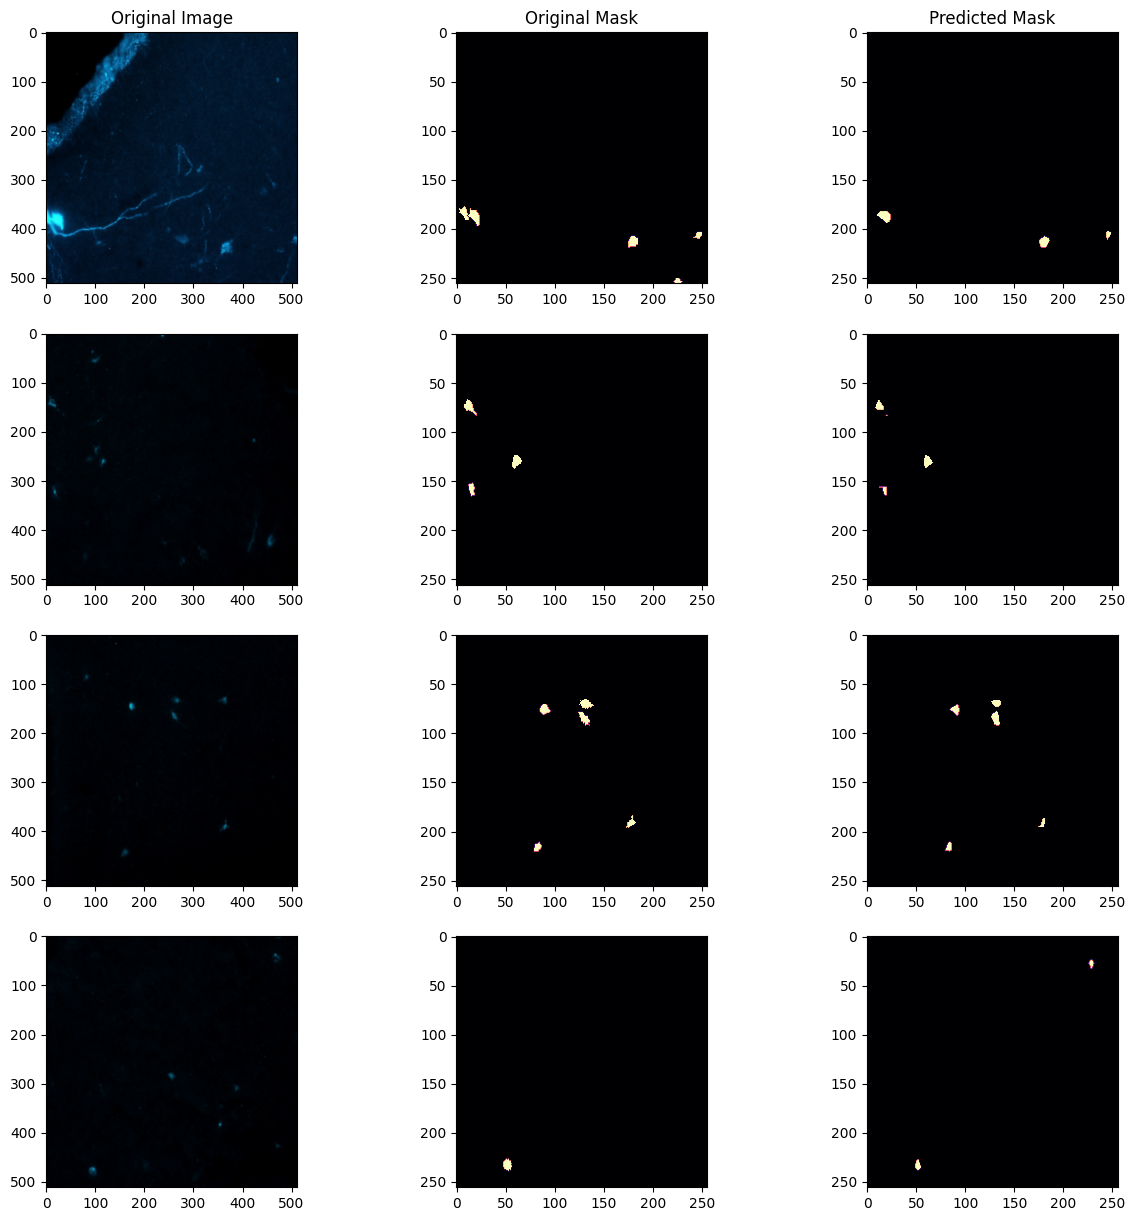

In [83]:
# Create the subplots to visualize all the images
f, ax = plt.subplots(batch_size, 3)
f.set_figheight(15)
f.set_figwidth(15)

# Plot each image in a different subplot
for i in range(batch_size):
    image = images[i]
    pred_mask = predicted_mask[i]
    mask = masks[i]
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, cmap="magma")
    ax[i, 2].imshow(pred_mask, cmap="magma")
    
ax[0, 0].set_title("Original Image")
ax[0, 1].set_title("Original Mask")
ax[0, 2].set_title("Predicted Mask")

plt.show()

The results are good. The model is able to predict the big neurons represented by the big patches, however it struggles when predicting small neurons. Another scenario where it seems to struggle is when there are neurons close to each other (see first prediction). 

Taking all into consideration, the results are pretty good. 

## Inference on images

When using the model to make predictions, we will not plot the three images, we need to return the predicted mask. A function is needed to make the prediction and format the prediction.

The `ModelCheckpoint` callback created a checkpoint of the best performing weights. This checkpoint will be used when loading the model, however, we need to specify the hyperparameters of the model. The `pl.LightningModule` allows us to specify this with the `hparams_file` parameter.

The block below examplifies a simple function to make a single prediction by receiving an image that is converted to numpy array and process by the `image_processor`. It is important to move the tensor to the `DEVICE` used to make the prediction. This vector will be passed to the model to make the prediction and get the logits that is the raw output. This raw output is passed to the `image_processor` to post-process the image and increase the size of the mask.

The function returns a dictionary with the original image and the mask detached from the GPU.

In [141]:
def make_single_prediction(image):
    # Instantiate the model from the checkpoint and using the hparams file
    mobilevit_model = MobileVIT.load_from_checkpoint(
        "../models/FluorescentMobileVIT/epoch=59-step=6120.ckpt", hparams_file=HPARAMS_FILE
    )
    # Instantiate the image_processor
    image_processor = AutoImageProcessor.from_pretrained(
        MODEL_CHECKPOINT, do_reduce_labels=False
    )
    # Convert the image to numpy array
    np_image = np.asarray(image, dtype=np.uint8)
    # Preprocess the image and move the image to the GPU Device
    processed_image = image_processor(images=np_image, return_tensors="pt")
    processed_image.to(DEVICE)
    # Make the prediction and resize the predicted mask
    logits = mobilevit_model.model(pixel_values=processed_image["pixel_values"])
    post_processed_image = image_processor.post_process_semantic_segmentation(
        outputs=logits, target_sizes=[(np_image.shape[0], np_image.shape[1])]
    )
    return {"image": image, "predicted_mask": post_processed_image[0].cpu()}

Select the image to make the prediction:

Text(0.5, 1.0, 'Test Image')

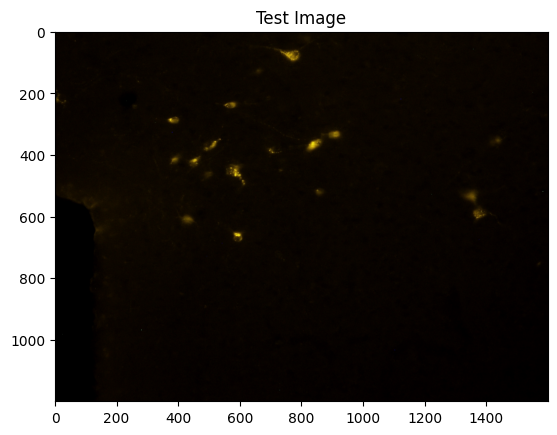

In [123]:
image_path = "../data/raw/all_images/images/Mar20bS2C1R1_DMr_200x_y.png"
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.title("Test Image")

Now we can make the prediction and plot the original image and the predicted mask.

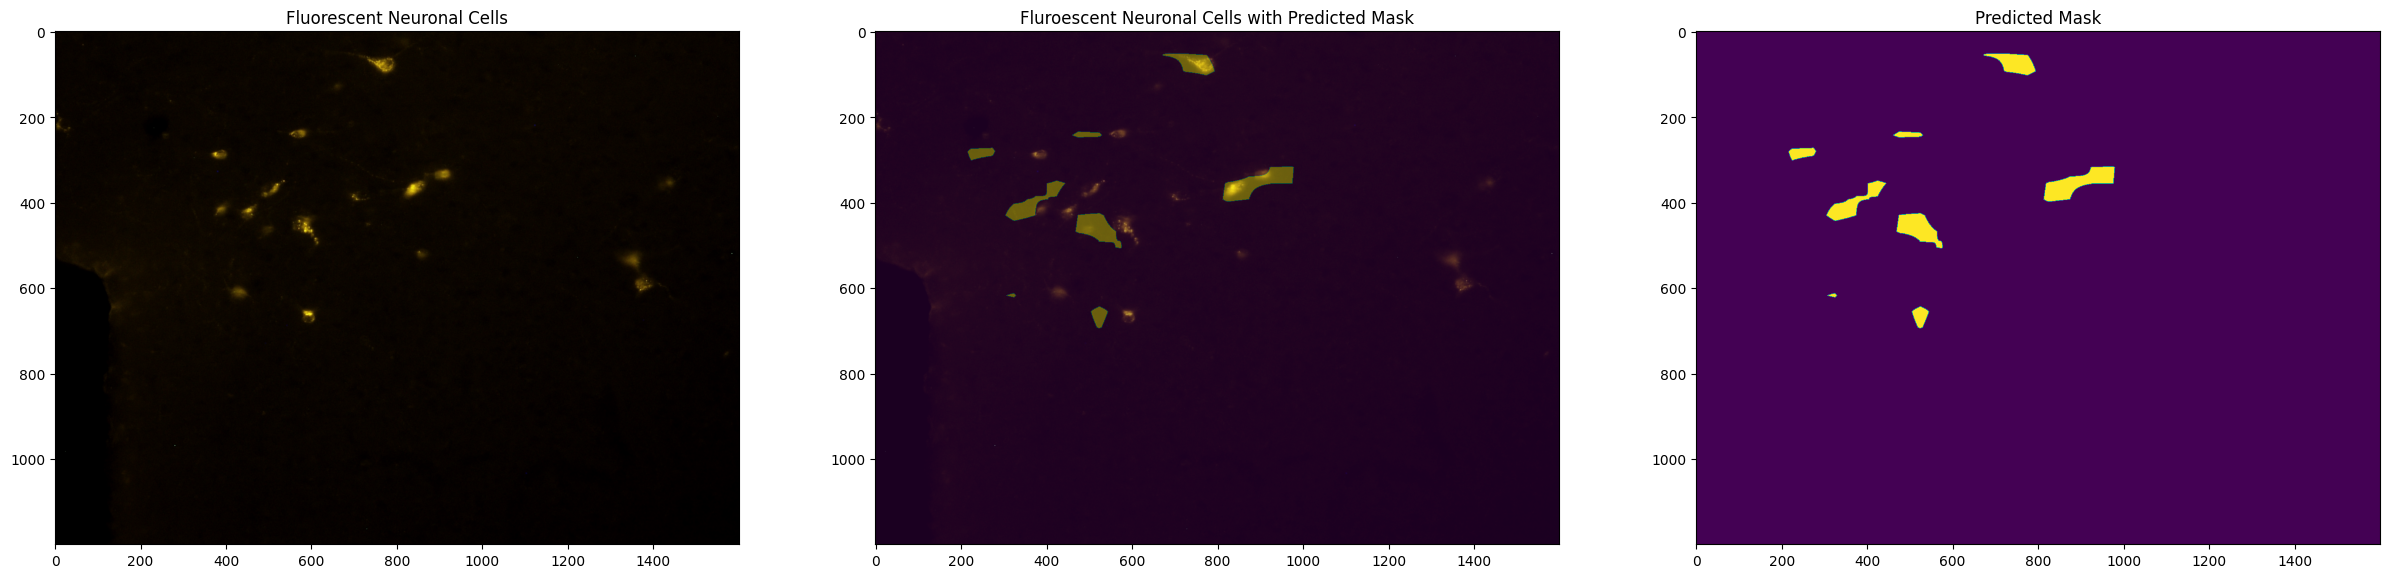

In [140]:
outputs = make_single_prediction(mobilevit_model, image_processor, image)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.imshow(outputs["image"])
plt.title("Fluorescent Neuronal Cells")

plt.subplot(1, 3, 2)
plt.imshow(outputs["image"])
plt.imshow(outputs["predicted_mask"], cmap="viridis", alpha=0.4)
plt.title("Fluroescent Neuronal Cells with Predicted Mask")

plt.subplot(1, 3, 3)
plt.imshow(outputs["predicted_mask"])
plt.title("Predicted Mask")

plt.show()